### Install modules in terminal

In [45]:
%pip install pandas scikit-learn numpy hmmlearn matplotlib joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import modules

In [46]:
import pandas as pd

import joblib
import numpy as np

import hmmlearn.hmm
from hmmlearn.hmm import MultinomialHMM, GaussianHMM

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import config

### HMM Model with 2024 data

In [47]:
training_df = pd.read_csv("../datasets/BTCUSDT_train_features.csv")

print(training_df)


                 timestamp      open      high       low     close  \
0      2018-01-01 17:00:00  13093.10  13248.60  13093.09  13138.11   
1      2018-01-01 18:00:00  13138.12  13321.23  13114.47  13189.98   
2      2018-01-01 19:00:00  13189.98  13350.00  13156.91  13345.47   
3      2018-01-01 20:00:00  13345.47  13544.24  13345.46  13469.01   
4      2018-01-01 21:00:00  13469.01  13772.59  13432.00  13565.00   
...                    ...       ...       ...       ...       ...   
26942  2021-01-29 11:00:00  36686.34  37307.28  36491.79  37108.69   
26943  2021-01-29 12:00:00  37106.18  37988.28  36622.22  37967.31   
26944  2021-01-29 13:00:00  37967.74  38570.13  37171.79  38458.99   
26945  2021-01-29 14:00:00  38499.99  38534.47  36570.00  37185.49   
26946  2021-01-29 15:00:00  37185.49  37619.92  36868.50  37178.27   

            volume        rsi         macd        ema_12        ema_26  \
0       380.269338  35.795321  -191.147212  13323.908819  13515.056031   
1       552

In [48]:
# # Load your data
# df = training_df

# # Convert to datetime
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# # Sort by time just in case
# df = df.sort_values('timestamp')

# # Drop NaN from the first row (due to shift)
# df = df.dropna()

# # Prepare observation sequence (log returns and normalized volume)
# df['volume_norm'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()
# df['rsi_norm'] = (df['rsi'] - df['rsi'].mean()) / df['rsi'].std()
# df['macd_norm'] = (df['macd'] - df['macd'].mean()) / df['macd'].std()
# df['ema12_norm'] = (df['ema_12'] - df['ema_12'].mean()) / df['ema_12'].std()
# df['ema26_norm'] = (df['ema_26'] - df['ema_26'].mean()) / df['ema_26'].std()
# df['sma20_norm'] = (df['sma_20'] - df['sma_20'].mean()) / df['sma_20'].std()
# df['volatility_norm'] = (df['volatility'] - df['volatility'].mean()) / df['volatility'].std()

# df = df.dropna()

# observations = df[['log_return', 'volume_norm', 'rsi_norm', 'macd_norm', 'ema12_norm', 'ema26_norm', 'sma20_norm', 'volatility_norm']].values
# # observations = df[['log_return', 'volume_norm']].values

# # Fit a Gaussian HMM with N hidden states
# hmmodel = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000) 
# hmmodel.fit(observations)

# # Predict the hidden states
# hidden_states = hmmodel.predict(observations)

# # Add hidden states to dataframe
# df['state'] = hidden_states

# print(df[['timestamp', 'open', 'close', 'log_return', 'state']])


In [ ]:
#Load your data
df = training_df

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by time just in case
df = df.sort_values('timestamp')

# Drop NaN from the first row (due to shift)
df = df.dropna()


# Initialize the StandardScaler
scaler = StandardScaler()

# Calculations for metrics
df['ohlc_mean'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['price_range'] = df['high'] - df['low']
df['candle_body'] = abs(df['close'] - df['open'])
df['direction'] = np.where(df['close'] > df['open'], 1, -1)
df['rolling_volatility'] = df['log_return'].rolling(window=14).std()
df['volume_ema'] = df['volume'].ewm(span=14).mean()
df['volume_spike'] = (df['volume'] - df['volume_ema']) / df['volume_ema']
df['bollinger_upper'] = df['sma_20'] + 2 * df['close'].rolling(window=20).std()
df['bollinger_lower'] = df['sma_20'] - 2 * df['close'].rolling(window=20).std()
df['bollinger_width'] = (df['bollinger_upper'] - df['bollinger_lower']) / df['sma_20']

# Prepare observation sequence (log returns and normalized volume)
df['volume_norm'] = scaler.fit_transform(df[['volume']])  # Standardize volume
df['rsi_norm'] = scaler.fit_transform(df[['rsi']])  # Standardize RSI
df['macd_norm'] = scaler.fit_transform(df[['macd']])  # Standardize MACD
df['ema12_norm'] = scaler.fit_transform(df[['ema_12']])  # Standardize EMA12
df['ema26_norm'] = scaler.fit_transform(df[['ema_26']])  # Standardize EMA26
df['sma20_norm'] = scaler.fit_transform(df[['sma_20']])  # Standardize SMA20
df['volatility_norm'] = scaler.fit_transform(df[['volatility']])  # Standardize volatility
df['ohlc_mean_norm'] = scaler.fit_transform(df[['ohlc_mean']])  # Standardize OHLC mean
df['price_range_norm'] = scaler.fit_transform(df[['price_range']])  # Standardize price range
df['candle_body_norm'] = scaler.fit_transform(df[['candle_body']])  # Standardize candle body
df['direction_norm'] = scaler.fit_transform(df[['direction']])  # Standardize direction
df['rolling_volatility_norm'] = scaler.fit_transform(df[['rolling_volatility']])  # Standardize rolling volatility
df['volume_ema_norm'] = scaler.fit_transform(df[['volume_ema']])  # Standardize volume EMA
df['volume_spike_norm'] = scaler.fit_transform(df[['volume_spike']])  # Standardize volume spike
df['bollinger_upper_norm'] = scaler.fit_transform(df[['bollinger_upper']])  # Standardize Bollinger upper band
df['bollinger_lower_norm'] = scaler.fit_transform(df[['bollinger_lower']])  # Standardize Bollinger lower band
df['bollinger_width_norm'] = scaler.fit_transform(df[['bollinger_width']])  # Standardize Bollinger width

df = df.dropna()

observations = df[['log_return', 'volume_norm', 'rsi_norm', 'macd_norm', 'ema12_norm', 'ema26_norm', 'sma20_norm', 'volatility_norm', 'ohlc_mean_norm', 'price_range_norm', 'candle_body_norm', 'direction_norm', 
                   'rolling_volatility_norm', 'volume_ema_norm', 'volume_spike_norm', 'bollinger_upper_norm', 'bollinger_lower_norm', 'bollinger_width_norm']].values
# observations = df[['log_return', 'volume_norm']].values

# Fit a Gaussian HMM with N hidden states
hmmodel = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, verbose=True)
hmmodel.fit(observations)

# Predict the hidden states
hidden_states = hmmodel.predict(observations)

# Add hidden states to dataframe
df['state'] = hidden_states

print(df[['timestamp', 'open', 'close', 'log_return', 'state']])

print("Converged:", hmmodel.monitor_.converged)
print("Final log likelihood:", hmmodel.monitor_.history[-1])
print(df['state'].value_counts(normalize=True))
print("Transition Matrix:\n", hmmodel.transmat_)




         1 -518986.11807359             +nan
         2 -278374.80736895 +240611.31070464
         3 -268805.62235965   +9569.18500930
         4 -264492.14031064   +4313.48204900
         5 -261516.93844078   +2975.20186986
         6 -258853.88314622   +2663.05529456
         7 -253937.00555135   +4916.87759487
         8 -248270.15011055   +5666.85544080
         9 -244485.29613145   +3784.85397910
        10 -242084.11808564   +2401.17804580
        11 -240232.29965576   +1851.81842988
        12 -238902.40307653   +1329.89657923
        13 -237879.01635644   +1023.38672009
        14 -237156.09123176    +722.92512468
        15 -236688.05472798    +468.03650378
        16 -236389.63822865    +298.41649933
        17 -236170.43474543    +219.20348322
        18 -236015.38965163    +155.04509380
        19 -235896.97748340    +118.41216823
        20 -235805.42487491     +91.55260849
        21 -235738.34550120     +67.07937370
        22 -235686.84664115     +51.49886005
        23

                timestamp      open     close  log_return  state
19    2018-01-02 12:00:00  13640.01  13632.00   -0.000983      1
20    2018-01-02 13:00:00  13632.00  13969.57    0.024461      2
21    2018-01-02 14:00:00  13969.57  13859.00   -0.007947      2
22    2018-01-02 15:00:00  13858.99  13741.01   -0.008550      2
23    2018-01-02 16:00:00  13741.01  13690.00   -0.003719      2
...                   ...       ...       ...         ...    ...
26942 2021-01-29 11:00:00  36686.34  37108.69    0.011150      2
26943 2021-01-29 12:00:00  37106.18  37967.31    0.022874      2
26944 2021-01-29 13:00:00  37967.74  38458.99    0.012867      2
26945 2021-01-29 14:00:00  38499.99  37185.49   -0.033674      2
26946 2021-01-29 15:00:00  37185.49  37178.27   -0.000194      2

[26928 rows x 5 columns]
Converged: True
Final log likelihood: -235529.45528727563
state
0    0.445001
1    0.411728
2    0.143271
Name: proportion, dtype: float64
Transition Matrix:
 [[9.15027796e-001 8.09901971e-002 3

        63 -235529.46455582      +0.01074711
        64 -235529.45528728      +0.00926854


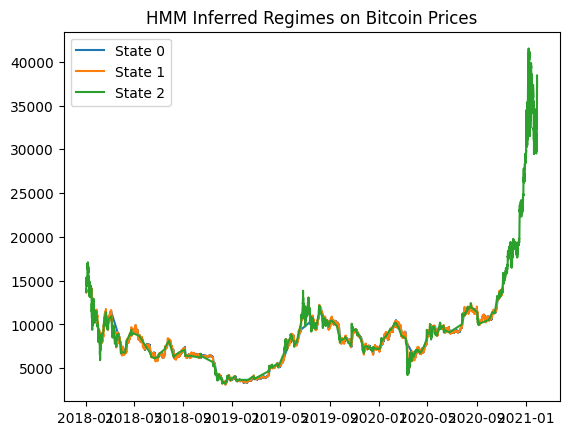

In [50]:
for i in range(hmmodel.n_components):
    state_series = df[df['state'] == i]
    plt.plot(state_series['timestamp'], state_series['close'], label=f'State {i}')

    #the state 0 represents a bear market (steady growth with low volatility) and state 1 represents a bull market (downward trend and high volatility)

plt.legend()
plt.title("HMM Inferred Regimes on Bitcoin Prices")
plt.show()

### Identify the meaning of the state number

In [51]:
# Calculate average return, volatility, and volume per state
state_analysis = df.groupby('state').agg({
    'log_return': ['mean', 'std'],
    'volume_norm': 'mean',
    'rsi_norm': 'mean',
    'macd_norm': 'mean',
    'ema12_norm': 'mean',
    'ema26_norm': 'mean',
    'sma20_norm': 'mean',
    'volatility_norm': 'mean',
    'ohlc_mean_norm': 'mean',
    'price_range_norm': 'mean',
    'candle_body_norm': 'mean',
    'direction_norm': 'mean',
    'rolling_volatility_norm': 'mean',
    'volume_ema_norm': 'mean',
    'volume_spike_norm': 'mean',
    'bollinger_upper_norm': 'mean',
    'bollinger_lower_norm': 'mean',
    'bollinger_width_norm': 'mean'
})

# Calculate the relative frequency (percentage) of each state
state_percentages = df['state'].value_counts(normalize=True) * 100

# Determine which state is most bullish (highest average return)
bullish_state = state_analysis['log_return']['mean'].idxmax()
print("\nState considered Bullish =", bullish_state)

# Determine which state is most bearish (lowest average return)
bearish_state = state_analysis['log_return']['mean'].idxmin()
print("State considered Bearish =", bearish_state)

# Determine the Neutral state (neither max nor min return)
neutral_state = list(set(df['state'].unique()) - {bullish_state, bearish_state})[0]
print("State considered Neutral =", neutral_state)

# #Update the state labels in config.py
# config.STATE_LABELS['bullish'] = int(bullish_state)
# config.STATE_LABELS['bearish'] = int(bearish_state)
# config.STATE_LABELS['neutral'] = int(neutral_state)

# # Print the state mapping and analysis
# print("\nPercentage of each state:")
# print(state_percentages)

# print("\n=== State Analysis === ")
# print(state_analysis)

# # Save the updated config to a file
# with open('config.py', 'w') as f:
#     f.write(f"STATE_LABELS = {config.STATE_LABELS}\n")


# # Add market_state labels based on analysis
# state_mapping = {
#     bullish_state: 'bullish',
#     bearish_state: 'bearish',
#     neutral_state: 'neutral'
# }
# df['market_state'] = df['state'].map(state_mapping)
# print(df[['timestamp', 'open', 'close', 'log_return', 'state', 'market_state']])
# Update the state labels in config.py
config.STATE_LABELS = {
    int (bullish_state): 'bullish',
    int (bearish_state): 'bearish',
    int (neutral_state): 'neutral'
}

# Print the state mapping and analysis
print("\nPercentage of each state:")
print(state_percentages)

print("\n=== State Analysis === ")
print(state_analysis)

# Save the updated config to a file (only write the correct STATE_LABELS)
with open('config.py', 'w') as f:
    f.write(f"STATE_LABELS = {config.STATE_LABELS}\n")

# Add market_state labels based on analysis (this step is separate and unrelated to config.py)
state_mapping = {
    bullish_state: 'bullish',
    bearish_state: 'bearish',
    neutral_state: 'neutral'
}
df['market_state'] = df['state'].map(state_mapping)
print(df[['timestamp', 'open', 'close', 'log_return', 'state', 'market_state']])



State considered Bullish = 1
State considered Bearish = 2
State considered Neutral = 0

Percentage of each state:
state
0    44.500149
1    41.172757
2    14.327094
Name: proportion, dtype: float64

=== State Analysis === 
      log_return           volume_norm  rsi_norm macd_norm ema12_norm  \
            mean       std        mean      mean      mean       mean   
state                                                                   
0       0.000059  0.002514   -0.449979 -0.023638 -0.033474  -0.385148   
1       0.000080  0.007365    0.069542  0.005574 -0.010229  -0.115464   
2      -0.000155  0.018872    1.197379  0.058224  0.136597   1.524384   

      ema26_norm sma20_norm volatility_norm ohlc_mean_norm price_range_norm  \
            mean       mean            mean           mean             mean   
state                                                                         
0      -0.385634  -0.385364       -0.511007      -0.384601        -0.425821   
1      -0.115605  -0.

In [52]:
# # Calculate average return, volatility, and volume per state
# state_analysis = df.groupby('state').agg({
#     'log_return': ['mean', 'std'],
#     'volume_norm': 'mean',
#     'rsi_norm': 'mean',
#     'macd_norm': 'mean',
#     'ema12_norm': 'mean',
#     'ema26_norm': 'mean',
#     'sma20_norm': 'mean',
#     'volatility_norm': 'mean'
# })

# # Calculate the relative frequency (percentage) of each state
# state_percentages = df['state'].value_counts(normalize=True) * 100

# print("Percentage of each state:")
# print(state_percentages)


# print("\n=== State Analysis (to identify the meaning of each state, the highest the log return, the market is bullish) === ")
# print(state_analysis)

# # Determine which state is most bullish (highest average return)
# bullish_state = state_analysis['log_return']['mean'].idxmax()
# print("\nState considered Bullish =", bullish_state)

# # Determine which state is most bearish (lowest average return)
# bearish_state = state_analysis['log_return']['mean'].idxmin()
# print("State considered Bearish =", bearish_state)

# # Determine the Neutral state (neither max nor min return)
# neutral_state = list(set(df['state'].unique()) - {bullish_state, bearish_state})[0]
# print("State considered Neutral =", neutral_state)

# # Add market_state labels based on analysis
# state_mapping = {
#     bullish_state: 'bullish',
#     bearish_state: 'bearish',
#     neutral_state: 'neutral'
# }
# df['market_state'] = df['state'].map(state_mapping)
# print(df[['timestamp', 'open', 'close', 'log_return', 'state', 'market_state']])


### Export the model

In [53]:
joblib.dump(hmmodel, '../models/hmm.pkl')


['../models/hmm.pkl']